In [1]:
%matplotlib notebook

%matplotlib inline

import sys

if "." not in sys.path:
    sys.path.insert(0, ".")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string
import seaborn as sns

import scipy as sp
from scipy import sparse
import sklearn

## add your packages ##

# Transformation
from bioinfokit.analys import norm

# 2D Visualization
from sklearn.decomposition import PCA
from openTSNE import TSNE
import umap

# metrics
from dcor import distance_correlation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import OneHotEncoder

# clustering
import igraph as ig
import leidenalg as la
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# other
from tqdm import tqdm
from utils import *

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import black
import jupyter_black

jupyter_black.load(line_length=79)
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
intermediate_path = Path("../results/intermediate")
data_path = Path("./data")
plt.style.use("../matplotlib_style.txt")

np.random.seed(42)

# TODO: make plots interactive
# TODO: Show electrophyisology data in section 3
# TODO: Compare NBMM with other groups
# TODO: Section 4 quantitative Analysis and text
# TODO: Section 5

# TODO: Revision

/Users/leander/opt/anaconda3/envs/nds/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leander/opt/anaconda3/envs/nds/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leander/opt/anaconda3/envs/nds/lib/python3.10/site-packag

# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    

# 0. Data Loading 

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [2]:
# META DATA

meta = pd.read_csv(data_path / "m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [3]:
# READ COUNTS

data_exons = pd.read_csv(
    data_path / "m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)
data_exons

Count matrix shape (exon):   (1329, 42466)


,20171204_sample_2,20171204_sample_4,20171204_sample_5,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171207_sample_6,20171207_sample_7,20171219_sample_1,20171219_sample_2,...,20191114_sample_9,20200106_sample_1,20200106_sample_4,20200106_sample_5,20200106_sample_6,20200225_sample_2,20200225_sample_5,20200316_sample_1,20200316_sample_2,20200316_sample_3
0610005C13Rik,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,0,68,1291,0,0,0,227,0,7,10,...,0,271,0,0,0,0,138,0,78,89
0610009E02Rik,0,0,0,0,30,80,205,0,0,14,...,0,0,0,0,0,0,1,0,0,0
0610009L18Rik,0,0,0,0,0,99,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-TSaga9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# GENE LENGTH

data = pd.read_csv(data_path / "gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

print("Number of genes:", len(genes))
genes

Number of genes: 42466


array(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', ..., 'n-R5s98',
       'n-TSaga9', 'n-TStga1'], dtype=object)

### Cluster colors

In [5]:
cluster_colors = np.load(data_path / "cluster_colors.npy")
cluster_colors.shape

(1329,)

In [6]:
rna_type = np.load(data_path / "rna_type.npy", allow_pickle=True)
rna_type.shape

(1329,)

In [7]:
pickle_in = open(data_path / "dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)
len(dict_rna_type_colors)

88

### Electrophysiological features

In [8]:
# EPHYS DATA

ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [9]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]
# get actual names of features
ephysNames_filtered = ephysNames[~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)
cells_filtered = cells[keepcells]

(1329, 29)
(1320, 17)


In [10]:
# eliminate cells that do not have electrophysiological data
exonCounts = exonCounts[keepcells, :]
cluster_colors = cluster_colors[keepcells]
rna_type = rna_type[keepcells]

# 1. Data Inspection

**Description of the relevant data:**
- exonCounts: Array of dimensions $n_{cells} \times n_{genes}$. Holds the read counts of the genes for every cell.
- exonLengths: Array of dimensions $n_{genes} \times 1$. Holds the lengths of the respective genes. Needed for some normalization techniques.
- genes: Array of dimensions $n_{genes} \times 1$. Holds the names of the genes.
- cluster_colors: Array of dimensions $n_{cells} \times 1$. Holds membership information to a cluster of each cell.
- rna_type: Array of dimensions $n_{cells} \times 1$. Holds information about the RNA type of each cell.
- ephysData: Array of dimensions $n_{cells} \times 29$. Holds values of overall 29 explored electrophysical features of each cell.
- ephysNames: Names of the explored electrophysical features.
 

In [11]:
# print shapes of relevant data
print("shape of exonCounts: ", exonCounts.shape)
print("shape of exonLengths: ", exonLengths.shape)
print("shape of genes: ", genes.shape)
print("shape of cluster_colors: ", cluster_colors.shape)
print("shape of rna_type: ", rna_type.shape)
print("shape of ephysData_filtered: ", ephysData_filtered.shape)

shape of exonCounts:  (1320, 42466)
shape of exonLengths:  (42466,)
shape of genes:  (42466,)
shape of cluster_colors:  (1320,)
shape of rna_type:  (1320,)
shape of ephysData_filtered:  (1320, 17)



Before we begin we remove all genes that exhibit no expression.

In [12]:
# kick out genes with no expression
keepgenes = np.sum(exonCounts, axis=0) > 0
exonCounts = exonCounts[:, keepgenes]
genes = genes[keepgenes]
exonLengths = exonLengths[keepgenes]

## 1.1 Feature Selection

In accordance with the methodology proposed by Kobak & Berens (2019), we choose features (genes) based on their mean-dropout relationship, as described by Andrews and Hemberg (2018).

In [13]:
# exclude genes with less than 32 counts in all but 10 cells
cmin = 32
n_cells = np.sum(exonCounts >= cmin, axis=0)
exclude = n_cells < 10

exonCounts_filtered = exonCounts[:, ~exclude]
genes_filtered = genes[~exclude]
exonLengths_filtered = exonLengths[~exclude]


# Calculate Mean Log Non-Zero Expression and Dropout Rate for Each Gene
# dropout rate
d_g = np.mean(exonCounts_filtered <= cmin, axis=0)

# mean log non-zero expression
# write ones for every value that is less than or equal to cmin (log(1) = 0)
variable_exonCount_log = exonCounts_filtered.copy()
variable_exonCount_log[exonCounts_filtered <= cmin] = 1
variable_exonCount_log = np.log2(variable_exonCount_log)
m_g = np.array(
    [
        np.mean(
            variable_exonCount_log[:, i][variable_exonCount_log[:, i] != 0]
        )
        for i in range(variable_exonCount_log.shape[1])
    ]
)

In [14]:
# boundary function to get the threshold (adopted from Kobak & Berens 2019)
def boundary(mu, b):
    return np.exp(-1.5 * (mu - b)) + 0.02


# perform binary search to get 500 genes that fullfil the criteria
def binary_search(mu, num_genes):
    """
    Binary search for the optimal value of theta
    """
    alpha_min = 0
    alpha_max = 500
    alpha = (alpha_min + alpha_max) / 2
    i = 0
    while np.sum(d_g > boundary(mu, alpha)) != num_genes and i < 1000:
        if np.sum(d_g > boundary(mu, alpha)) < num_genes:
            alpha_max = alpha
        else:
            alpha_min = alpha
        alpha = (alpha_min + alpha_max) / 2
        # print(alpha)
        i += 1
    return alpha, d_g > boundary(mu, alpha)


offset, idx = binary_search(m_g, 500)

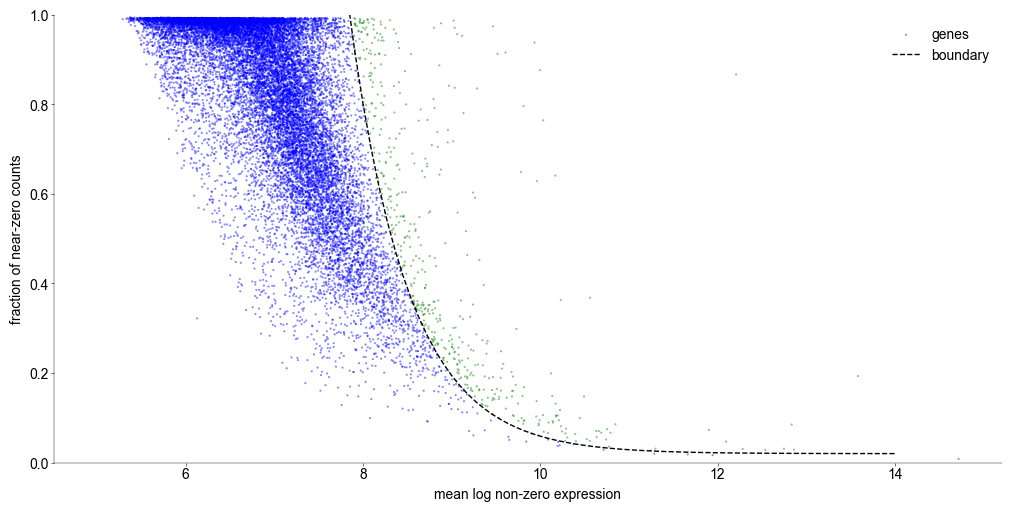

In [15]:
# TODO: make this interactive ?
x = np.linspace(5, 14, 100)

boundary_colors = np.array(["blue", "green"])[
    (d_g > boundary(m_g, offset)).astype(int)
]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(m_g, d_g, s=1, c=boundary_colors, label="genes", alpha=0.5)
ax.set_xlabel("mean log non-zero expression")
ax.set_ylabel("fraction of near-zero counts")
ax.set_ylim(0, 1)
ax.plot(
    x, boundary(x, offset), color="black", linestyle="--", label="boundary"
)

ax.legend()

plt.show()

In [16]:
exonCounts_filtered = exonCounts_filtered[:, idx]
genes_filtered = genes_filtered[idx]
exonLengths_filtered = exonLengths_filtered[idx]

## 1.1. Compute Statistics

Do we want to calculate the statistics of the filtered data or of the exonCounts before manipulating it? 

In [17]:
# Compute the average expression for each gene
avg_expr = np.mean(exonCounts_filtered, axis=0)
frac_zeros = np.mean(exonCounts_filtered == 0, axis=0)

# compute variance
var_expr = np.var(exonCounts_filtered, axis=0)

# Compute fano factor
fano_factor = var_expr / avg_expr

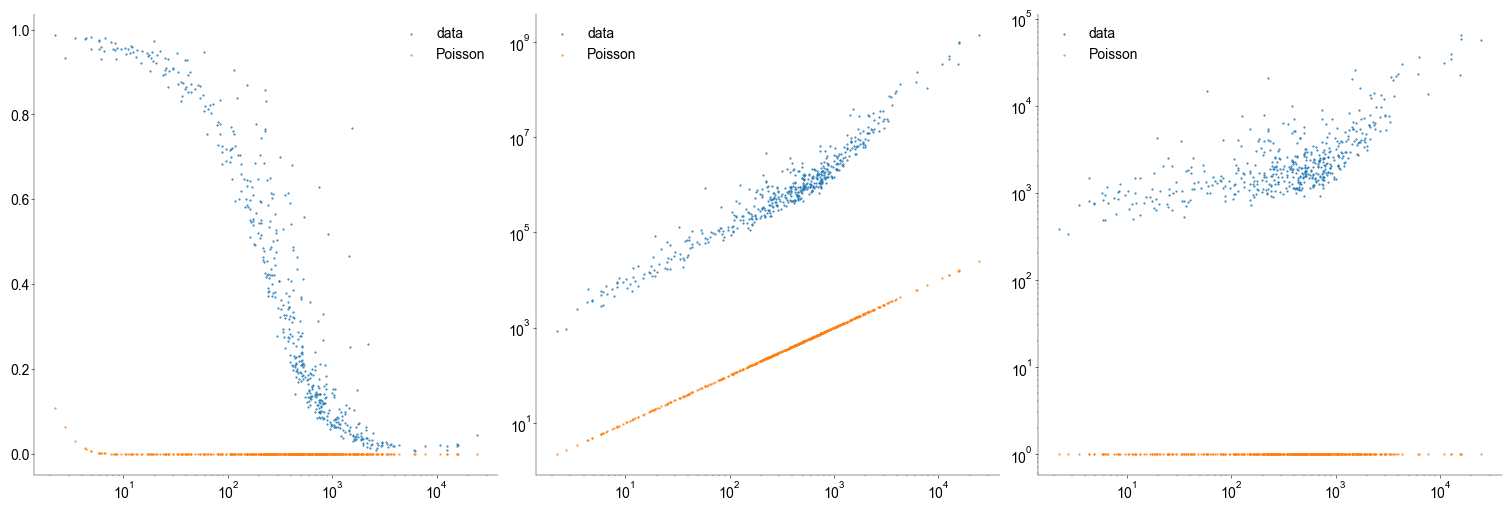

In [18]:
# visualize that the distribution does indeed not follow a poisson distribution

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(avg_expr, frac_zeros, s=1, label="data")
axs[0].scatter(avg_expr, np.exp(-avg_expr), s=1, label="Poisson")

axs[1].scatter(avg_expr, var_expr, s=1, label="data")
axs[1].scatter(avg_expr, avg_expr, s=1, label="Poisson")

axs[2].scatter(avg_expr, fano_factor, s=1, label="data")
axs[2].scatter(avg_expr, np.ones_like(avg_expr), s=1, label="Poisson")

for i, ax in enumerate(axs):
    ax.set_xscale("log")
    if i != 0:
        ax.set_yscale("log")
    ax.legend()

plt.show()

**Analysis:** We can see what was already given in the task description, i.e. that the data does not follow a Poisson distribution because it is not acquired via UMI.

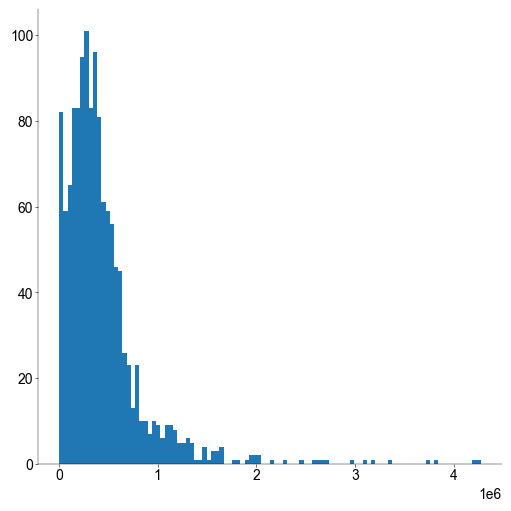

In [19]:
# plot sequencing depth of each cell

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(np.sum(exonCounts_filtered, axis=1), bins=100)

plt.show()

# 2. Data Normalization and Transformation


In the exercise sheet related to transcriptomic data analysis, we standardized the counts by expressing them as counts per median sequencing depth. Since the data does not consist of unique molecular identifier (UMI) counts, we applied two distinct normalization methods: counts per million (CPM) and reads per kilobase per million (RPKM). Additionally, we applied both log-transformation and square root-transformation to the normalized data in each case.


## 2.1. Counts per million (CPM)

In order to obtain CPM, we have to perform the following calculation for each cell:

$$ CPM = \frac{\text{Read counts mapped to gene}}{\text{Total number of mapped reads}} \times 10^6 $$

For this, the bioinfokit.analys library is used.


In [20]:
# convert exonCounts to dataframe
df = pd.DataFrame(
    exonCounts_filtered.T, columns=cells_filtered, index=genes_filtered
)

In [21]:
# Normalization: CPM
nm = norm()
nm.cpm(df)
cpm_df = nm.cpm_norm


# Transformation: Log2 and sqrt transform
cpm_counts = cpm_df.values.T
cpm_counts_log = np.log2(cpm_counts + 1)  # + 1 to avoid log(0)
cpm_counts_sqrt = np.sqrt(cpm_counts)

## 2.3. Reads per kilobase per million (RPKM)

RPKM addresses the issue of variations in gene lengths and sequencing depths:

$$ RPKM = \frac{{\text{Number of uniquely mapped reads to the gene}}}{{\text{gene length in KB} \times \text{Total mapped reads in the sample}}} \times 10^6$$

Again, we use the bioinfokit package to obtain the normalized counts.

In [22]:
# add column with lengths to df
df["length"] = exonLengths_filtered

# Normalization
nm = norm()
nm.rpkm(df=df, gl="length")
rpkm_df = nm.rpkm_norm

# Log and sqrt transform
rpkm_counts = rpkm_df.values.T
rpkm_counts_log = np.log(rpkm_counts + 1)
rpkm_counts_sqrt = np.sqrt(rpkm_counts)

# 3. Two-dimensional Visualization

In this section, our main objective is to create two-dimensional visualizations of our high-dimensional data. To achieve this, we utilize two algorithms: t-SNE and UMAP. You can find more detailed explanations of these algorithms in their respective sections.

To make the dimensionality reduction computationally feasible, we follow the approach proposed by Kobak and Berens (2019) and apply it to the first fifty principal components.

In evaluating the quality of the resulting visualizations, we begin by conducting a qualitative assessment. Subsequently, we utilize quantitative metrics such as KNN accuracy and distance correlation. Moreover, we have developed a combined score that incorporates these metrics, allowing us to gain more profound insights into the effectiveness of the visualization methods.

Furthermore, we leverage this combined score to conduct a grid search over the hyperparameters of the algorithms, aiming to optimize their performance.

## 3.1. Qualitative Analysis

In [23]:
# create a dictionary with the different count types to make it easy to iterate over them

count_dict = {
    "unnormalized": {
        "raw": exonCounts_filtered,
        "log": np.log2(exonCounts_filtered + 1),
        "sqrt": np.sqrt(exonCounts_filtered),
    },
    "cpm": {
        "raw": cpm_counts,
        "log": cpm_counts_log,
        "sqrt": cpm_counts_sqrt,
    },
    "rpkm": {
        "raw": rpkm_counts,
        "log": rpkm_counts_log,
        "sqrt": rpkm_counts_sqrt,
    },
}

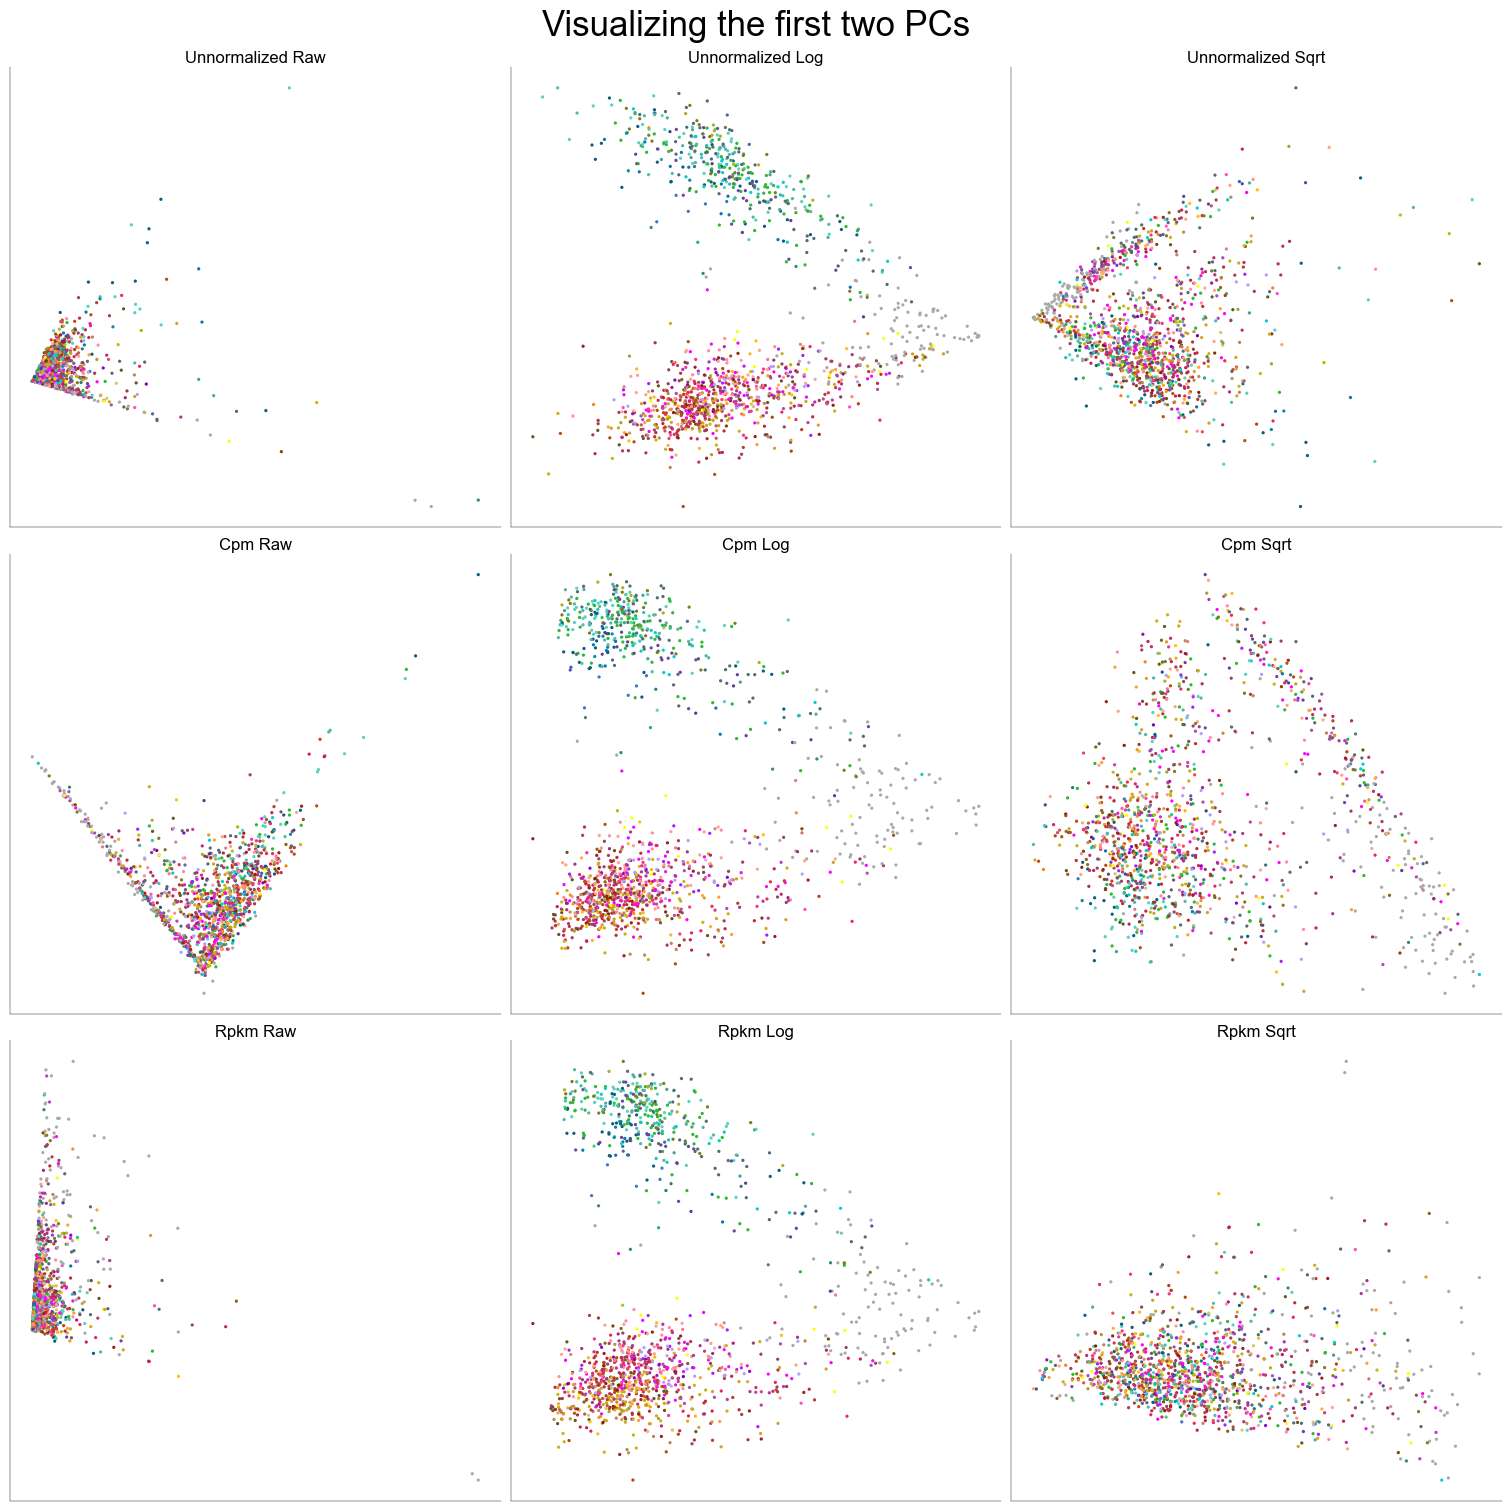

In [24]:
# perform PCA fit
pca = PCA(n_components=50)
pca_results = dict()
for norm_key, sub_dict in count_dict.items():
    pca_results[norm_key] = dict()
    for trans_key, counts in sub_dict.items():
        pca_results[norm_key][trans_key] = pca.fit_transform(counts)

# plot PCA results
plot_2d_vis(pca_results, "Visualizing the first two PCs", cluster_colors)

**Qualitative Analysis:** It appears that PCA alone is insufficient to unveil the clusters. Thus, it becomes necessary, as anticipated, to employ TSNE or UMAP. Presently, there has been no assessment of the various normalization methods' quality.

### 3.1.1. TSNE

**Description of the algorithm:**

TSNE (t-distributed Stochastic Neighbor Embedding) is a dimensionality reduction algorithm used to map high-dimensional data into a lower-dimensional space, typically for visualization purposes. It aims to preserve the relationships between data points, especially the local structure of the data, by mapping similar points close together and dissimilar points far apart. t-SNE achieves this by minimizing the divergence between two probability distributions: a pairwise similarity distribution $P_i|j$ in the high-dimensional space and a probability distribution $Q_i|j$ in the lower-dimensional space.

Objective function:
$$ C = \sum_{i} KL(P_i||Q_i) $$
(Kullback-Leibler Divergence)

Where:
- $P_i∣j$ represents the conditional similarity between data point i and j in the high-dimensional space. It is calculated using the similarities of data points and applying a Gaussian kernel:
$$ P_i|j = \frac{\exp\left(-\frac{\lVert x_i - x_j \rVert^2}{2\sigma_i^2}\right)}{\sum_{k \neq i}\exp\left(-\frac{\lVert x_i - x_k \rVert^2}{2\sigma_i^2}\right)} $$


- $Q_i|j$ represents the conditional similarity between data point i and j in the lower-dimensional space. It is calculated using the t-distribution:
$$ Q_i|j = \frac{\left(1 + \lVert y_i - y_j \rVert^2\right)^{-1}}{\sum_{k \neq l} \left(1 + \lVert y_k - y_l \rVert^2\right)^{-1}} $$

Here:
- $x_i$ and $x_j$ are the original high-dimensional feature vectors of data points $i$ and $j$, respectively.
- $y_i$ and $y_j$ are the lower-dimensional embeddings of data points $i$ and $j$, respectively.
- $\sigma_i$ is a parameter in the Gaussian kernel and is chosen based on the perplexity hyperparameter, controlling the number of neighbors.

The objective function is minimized through stochastic gradient descent to find the optimal lower-dimensional embeddings ($y_i$) that best represent the structure of the high-dimensional data in the reduced space, emphasizing on preserving local structures and clustering patterns.


In our scenario, we apply t-SNE to our PCA results, meaning we use a 50-dimensional $x$ for the TSNE transformation.

In [25]:
# perform t-SNE of PCA results with default parameters
tsne = TSNE()
tsne_results = dict()
for norm_key, sub_dict in pca_results.items():
    tsne_results[norm_key] = dict()
    for trans_key, result in sub_dict.items():
        tsne_results[norm_key][trans_key] = tsne.fit(result)

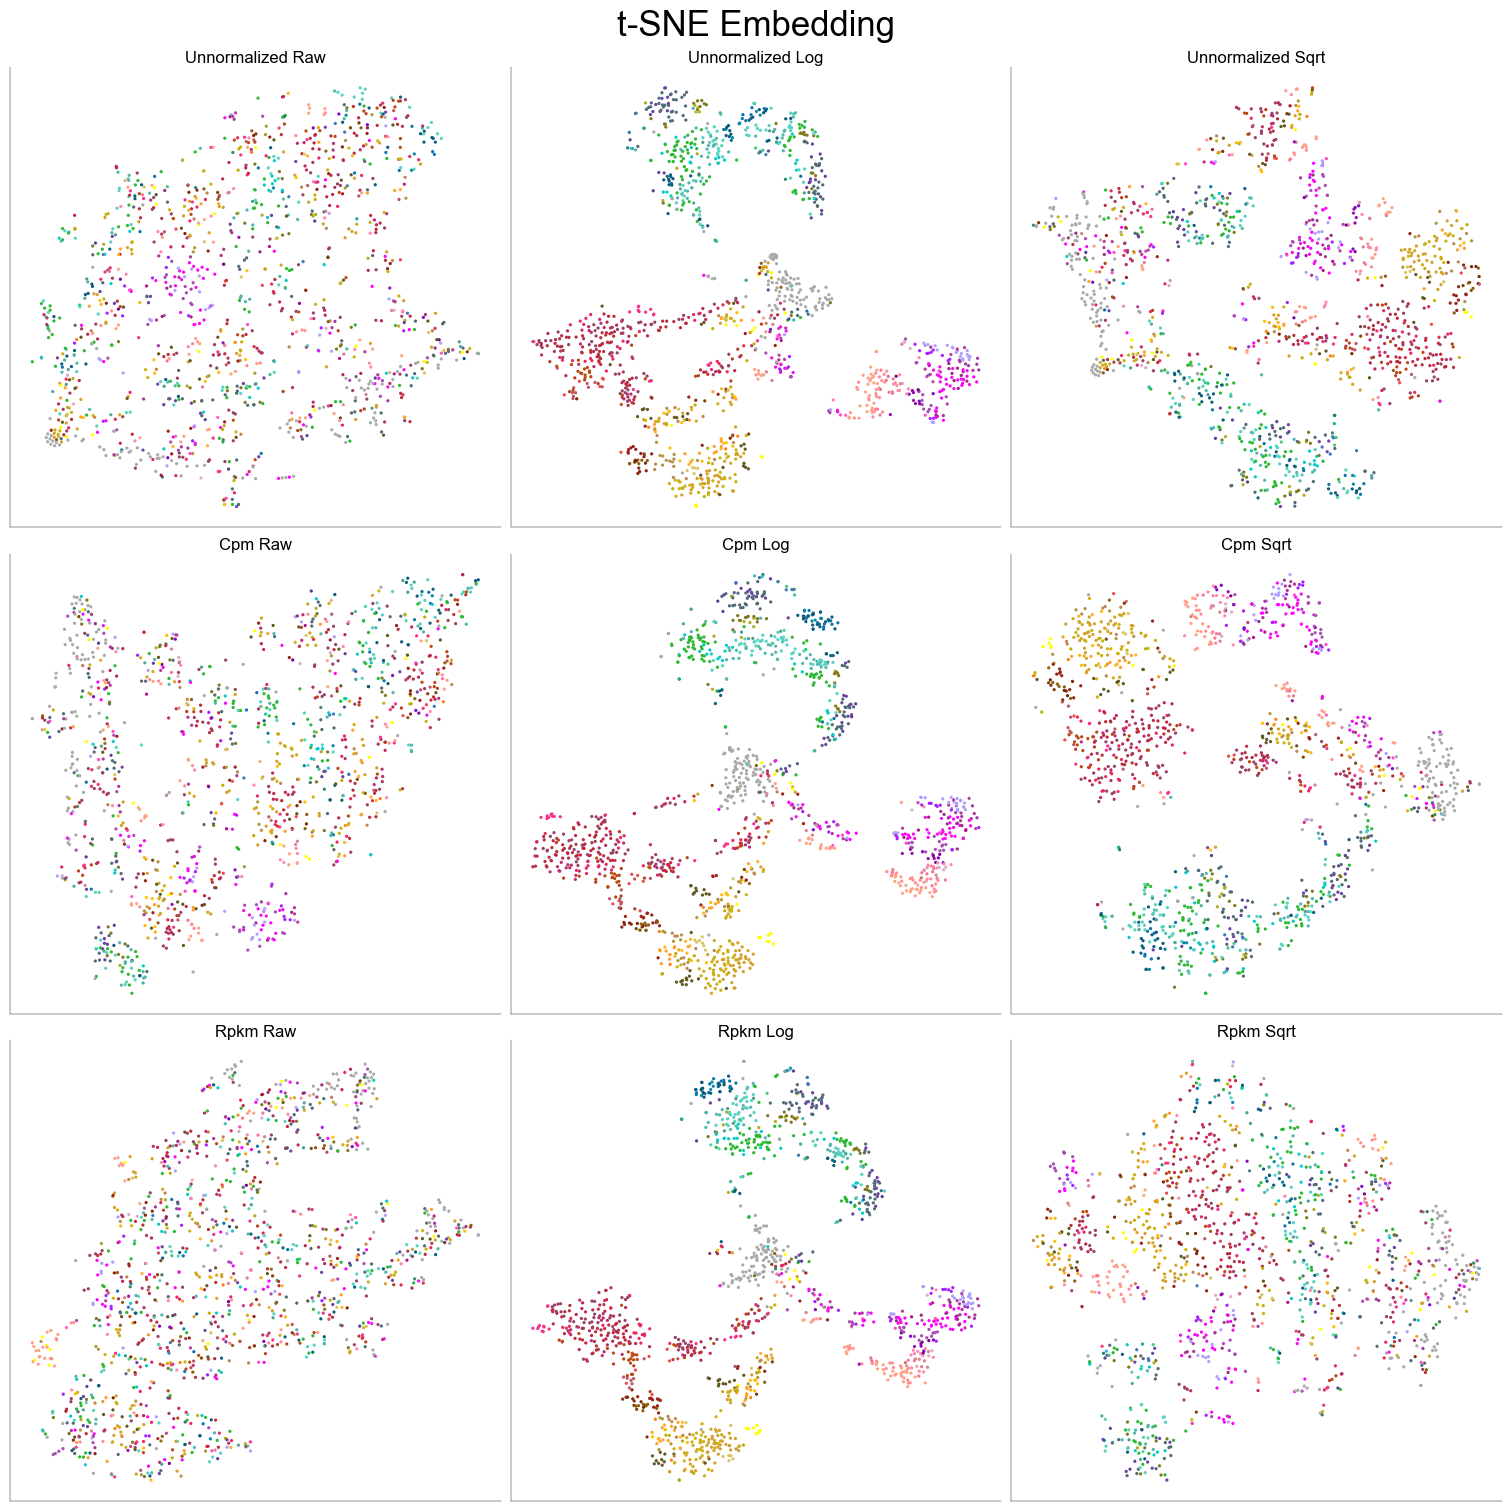

In [26]:
plot_2d_vis(tsne_results, "t-SNE Embedding", cluster_colors)

**Qualitative Analysis:** The original data (left column) does not exhibit satisfactory clustering results. The square-root transformation (right column) also shows limitations, especially when dealing with unnormalized and RPKM-normalized data. On the other hand, log-transformations (middle column) appear to yield the best results, although it is evident that the ground truth does not perfectly align with the cluster structure revealed by TSNE.

### 3.1.2. UMAP

**Descripton of the algorithm:** 

UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction algorithm used to transform high-dimensional data into a lower-dimensional representation. It aims to preserve the local and global structure of the data by finding a low-dimensional representation where similar data points are closer together while dissimilar points are further apart. UMAP achieves this by optimizing two main objectives:

1. Local Connectivity Preservation: It ensures that neighboring points in the high-dimensional space remain close to each other in the low-dimensional space. This is achieved by modeling the probability of a data point being a neighbor of another point in both the original high-dimensional space and the lower-dimensional space.
2. Minimizing Cross-Entropy: UMAP minimizes the cross-entropy between the pairwise probability distributions in the high-dimensional space and the pairwise probability distributions in the low-dimensional space. This step helps to ensure that the global structure of the data is preserved, allowing clusters and patterns to be well-represented in the lower-dimensional embedding.

In [27]:
umap_func = umap.UMAP()
umap_results = dict()
for norm_key, sub_dict in pca_results.items():
    umap_results[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        umap_results[norm_key][trans_key] = umap_func.fit_transform(pca_result)

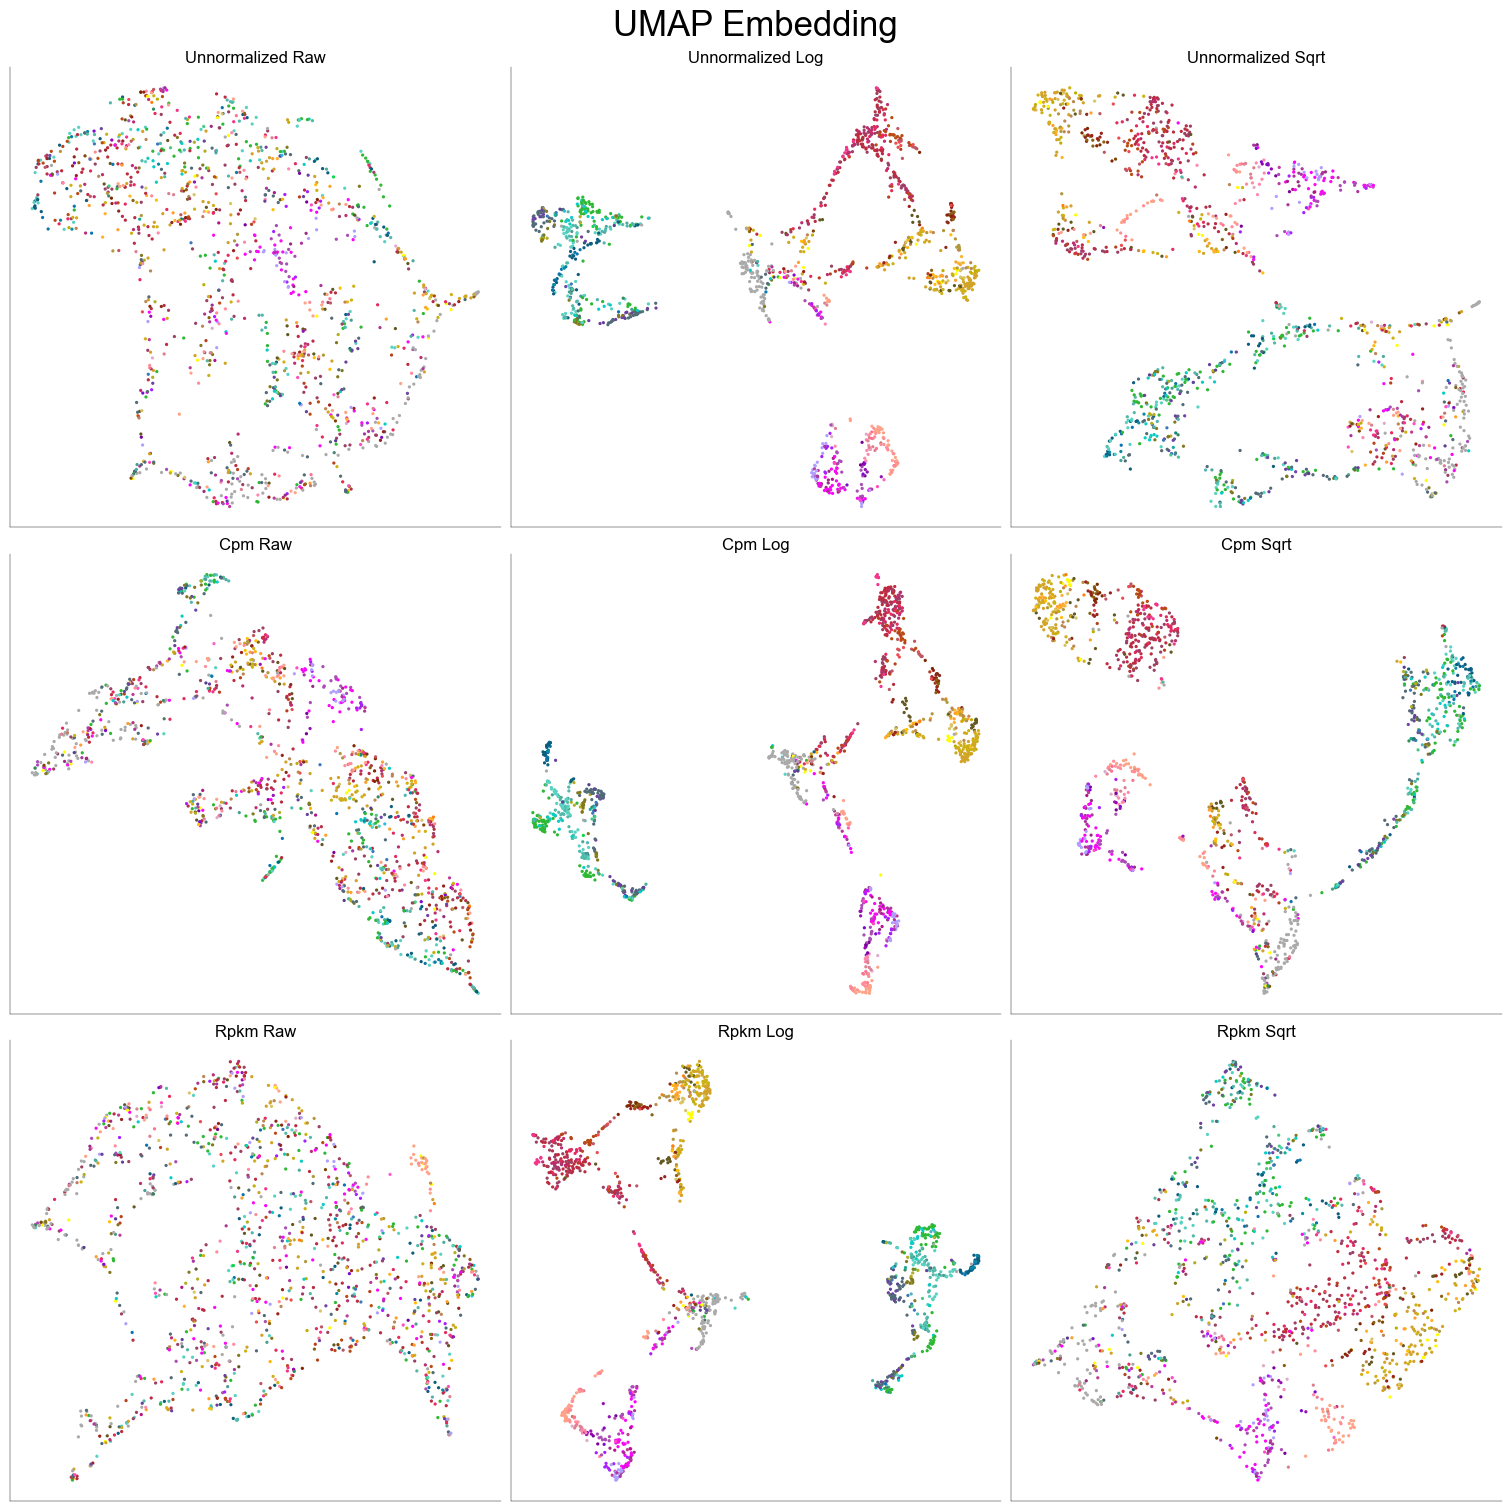

In [28]:
plot_2d_vis(umap_results, "UMAP Embedding", cluster_colors)

**Qualitative Analysis:** Similar to the previous observation, the original data (left column) does not produce satisfactory results in terms of clustering. The square-root transformation (right column) reveals the cluster structure better than TSNE. Nevertheless, our conclusion is that log-transformations (middle column) offer the most meaningful two-dimensional visual representation of the underlying ground truth cluster structure. 

As a result, we choose to focus our further, quantitative analysis solely on the middle column, disregarding the unnormalized log-transformed data (since normalization is standard in the literature). 

In [29]:
# remove keys from result dictionary

result_dicts = [count_dict, pca_results, tsne_results, umap_results]

remove_norms = ["unnormalized"]  # ["raw", "cpm", "rpkm"]
remove_transforms = ["raw", "sqrt"]  # ["counts", "log", "sqrt"]

for result_dict in result_dicts:
    for norm in remove_norms:
        try:
            del result_dict[norm]
        except KeyError:
            pass

for result_dict in result_dicts:
    for norm_key, sub_dict in result_dict.items():
        for trans in remove_transforms:
            try:
                del sub_dict[trans]
            except KeyError:
                pass

## 3.2. Quantitative Analysis

In order to subject our two-dimensional representations to quantitative analysis, we needed to make the results measurable. To achieve this, we employed KNN accuracy and distance correlation as our evaluation metrics. Additionally, we introduced a combined score to gain deeper insights into the results.

Furthermore, this combined score was utilized to conduct a grid search over the parameter space of TSNE, enabling us to identify the optimal hyperparameters for the algorithm.


### 3.2.1. Implementation of different Metrics

- Distance correlation: measures the similarity of pairwise distances in the original data space and the corresponding transformed space.
- KNN Accuracy:
- Combined Score: Mean of the distance correlation and the normalized KNN accuracy.




In [30]:
# Calculate distance correlation
pca_dc = dict()
tsne_dc = dict()
umap_dc = dict()

for norm_key, sub_dict in pca_results.items():
    pca_dc[norm_key] = dict()
    tsne_dc[norm_key] = dict()
    umap_dc[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        pca_dc[norm_key][trans_key] = distance_correlation(
            pca_result, pca_result[:, :2]
        )
        tsne_dc[norm_key][trans_key] = distance_correlation(
            pca_result, tsne_results[norm_key][trans_key]
        )
        umap_dc[norm_key][trans_key] = distance_correlation(
            pca_result, umap_results[norm_key][trans_key]
        )


print(f"PCA distance correlations: {pca_dc}")
print(f"TSNE distance correlations: {tsne_dc}")
print(f"UMAP distance correlations: {umap_dc}")

PCA distance correlations: {'cpm': {'log': 0.9332768651232}, 'rpkm': {'log': 0.9215071686030907}}
TSNE distance correlations: {'cpm': {'log': 0.7536883409031941}, 'rpkm': {'log': 0.7610615965849394}}
UMAP distance correlations: {'cpm': {'log': 0.7405141551896653}, 'rpkm': {'log': 0.7604354442050426}}


UMAP displays slightly worse scores than TSNE for both transformations.

In [31]:
str_rna_types = np.array([str(r) for r in rna_type])


# TODO is this what they meant?
def get_knn_score(input, gt_labels=str_rna_types):
    max_accuracy = 0
    for neighbor in range(1, 30):
        knn = KNeighborsClassifier(n_neighbors=neighbor)
        X_train, X_test, y_train, y_test = train_test_split(
            input, gt_labels, random_state=42
        )
        knn.fit(X_train, y_train)
        prediction = knn.predict(X_test)
        accuracy = accuracy_score(y_test, prediction)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_neighbor = neighbor
    return best_neighbor, max_accuracy

    # Note that the recall of the knn classifier is the same as the accuracy, for any of the averaging mode, as recall is a binary metric
    return [
        accuracy_score(y_test, prediction),
        recall_score(y_test, prediction, average="micro"),
    ]


def print_knn_scores(result_dict, title, f=lambda x: x):
    out_dict = dict()
    for norm_key, sub_dict in result_dict.items():
        out_dict[norm_key] = dict()
        for trans_key, pca_result in sub_dict.items():
            out_dict[norm_key][trans_key] = dict()
            out_dict[norm_key][trans_key].update(
                zip(
                    ["num_neighbors", "accuracy"],
                    get_knn_score(f(pca_result)),
                )
            )

    print(f"{title} knn accuracy/recall: {out_dict}")
    return out_dict


print(
    "Note that the recall of the knn classifier is the same as the accuracy, as recall is a binary metric\n"
)
high_dim_knn_score = print_knn_scores(pca_results, "PCA")
pca_knn_score = print_knn_scores(pca_results, "PCA 2D", lambda x: x[:, :2])
tsne_knn_score = print_knn_scores(tsne_results, "t-SNE")
umap_knn_score = print_knn_scores(umap_results, "UMAP")

Note that the recall of the knn classifier is the same as the accuracy, as recall is a binary metric

PCA knn accuracy/recall: {'cpm': {'log': {'num_neighbors': 5, 'accuracy': 0.5363636363636364}}, 'rpkm': {'log': {'num_neighbors': 7, 'accuracy': 0.5272727272727272}}}
PCA 2D knn accuracy/recall: {'cpm': {'log': {'num_neighbors': 19, 'accuracy': 0.18787878787878787}}, 'rpkm': {'log': {'num_neighbors': 21, 'accuracy': 0.20303030303030303}}}
t-SNE knn accuracy/recall: {'cpm': {'log': {'num_neighbors': 1, 'accuracy': 0.5363636363636364}}, 'rpkm': {'log': {'num_neighbors': 5, 'accuracy': 0.5121212121212121}}}
UMAP knn accuracy/recall: {'cpm': {'log': {'num_neighbors': 4, 'accuracy': 0.4909090909090909}}, 'rpkm': {'log': {'num_neighbors': 5, 'accuracy': 0.4696969696969697}}}


To achieve comparability in terms of the 2D respresentation, we calculate the accuracy score of the respective 2D representation divided by the knn accuracy 50-dimensional PCA respresentation over the thus normalizing it to the $[0, 1]$ interval

In [32]:
def normalize_knn_scores(scores):
    out_dict = dict()
    for norm_key, sub_dict in scores.items():
        out_dict[norm_key] = dict()
        for trans_key, score in sub_dict.items():
            out_dict[norm_key][trans_key] = (
                score["accuracy"]
                / high_dim_knn_score[norm_key][trans_key]["accuracy"]
            )

    return out_dict


print(f"PCA 2D knn normalized accuracy: {normalize_knn_scores(pca_knn_score)}")
print(f"t-SNE knn normalized accuracy: {normalize_knn_scores(tsne_knn_score)}")
print(f"UMAP knn normalized accuracy: {normalize_knn_scores(umap_knn_score)}")

PCA 2D knn normalized accuracy: {'cpm': {'log': 0.3502824858757062}, 'rpkm': {'log': 0.38505747126436785}}
t-SNE knn normalized accuracy: {'cpm': {'log': 1.0}, 'rpkm': {'log': 0.9712643678160919}}
UMAP knn normalized accuracy: {'cpm': {'log': 0.9152542372881356}, 'rpkm': {'log': 0.8908045977011495}}


Again, we note that TSNE shows slightly better scores than UMAP.

Now that we have two scores that are both in the interval $[0, 1]$ we can combine them, i.e. taking the mean, to create an even more informed score

In [33]:
def get_combined_score(high_dim_matrix, low_dim_matrix):
    _, high_dim_accuracy = get_knn_score(high_dim_matrix)
    _, accuracy = get_knn_score(low_dim_matrix)
    dc = distance_correlation(high_dim_matrix, low_dim_matrix)
    return np.mean([accuracy / high_dim_accuracy, dc])


def get_all_combined_scores(result_dict, f=lambda x: x):
    out_dict = dict()
    for norm_key, sub_dict in result_dict.items():
        out_dict[norm_key] = dict()
        for trans_key, result in sub_dict.items():
            out_dict[norm_key][trans_key] = get_combined_score(
                pca_results[norm_key][trans_key], f(result)
            )

    return out_dict


print(
    f"PCA 2D combined score: {get_all_combined_scores(pca_results, lambda x: x[:, :2])}"
)
print(f"t-SNE combined score: {get_all_combined_scores(tsne_results)}")
print(f"UMAP combined score: {get_all_combined_scores(umap_results)}")

PCA 2D combined score: {'cpm': {'log': 0.6417796754994531}, 'rpkm': {'log': 0.6532823199337292}}
t-SNE combined score: {'cpm': {'log': 0.876844170451597}, 'rpkm': {'log': 0.8661629822005157}}
UMAP combined score: {'cpm': {'log': 0.8278841962389005}, 'rpkm': {'log': 0.8256200209530961}}


Consequently, TSNE also provides a better combined score for both normalizations (log-transformed). Within TSNE the CPM normalization has the highest score.

### 3.2.2. Gridsearch over TSNE hyperparameters

As mentioned earlier, the TSNE algorithm involves two hyperparameters that the user needs to provide, and these values can be optimized. In the following we intend to employ a grid search scheme over discrete set of values to determine the best ones. The set was selected through visual assessment after a few attempts.

In [34]:
def tsne_gridsearch(
    pca_result, perplexity_space, exaggeration_space, metric, progress_bar=None
):
    max_score = 0
    for perplexity in perplexity_space:
        for exaggeration in exaggeration_space:
            tsne = TSNE(
                perplexity=perplexity,
                exaggeration=None if exaggeration == 0 else exaggeration,
            )
            tsne_result = tsne.fit(pca_result)
            score = metric(pca_result, tsne_result)
            if score > max_score:
                max_score = score
                best_perplexity = perplexity
                best_exaggeration = exaggeration
                best_result = tsne_result
            if progress_bar is not None:
                progress_bar.update(1)
    return best_result, max_score, best_perplexity, best_exaggeration

In [35]:
# WARNING this cell takes a significant amount of time to run
# you can skip the execution and thake the results from the next cell

# maximum perplexity imposed by t-SNE
# (giving a perplexity higher than this will result in using this number regardless)
max_perplexity = (
    int(list(list(pca_results.values())[0].values())[0].shape[0] / 3) - 1
)

# for the following, we choose a more realistic maximum perplexity to reduce runtime
max_perplexity = 50

# search spaces
perplexity_space = np.linspace(1, max_perplexity, 10, dtype=int)
exaggeration_space = np.linspace(0, 4, 4, dtype=int)

tsne_results = dict()
tsne_dc = dict()
tsne_hyperparams = dict()
progress_bar = tqdm(
    total=perplexity_space.shape[0]
    * exaggeration_space.shape[0]
    * len(pca_results.items())
    * len(list(pca_results.values())[0].items())
)
for norm_key, sub_dict in pca_results.items():
    tsne_results[norm_key] = dict()
    tsne_dc[norm_key] = dict()
    tsne_hyperparams[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        (
            tsne_results[norm_key][trans_key],
            tsne_dc[norm_key][trans_key],
            tsne_hyperparams[norm_key]["perplexity"],
            tsne_hyperparams[norm_key]["exaggeration"],
        ) = tsne_gridsearch(
            pca_result,
            perplexity_space,
            exaggeration_space,
            get_combined_score,
            progress_bar,
        )
        time.sleep(1)
progress_bar.close()

# save results
pickle_out = open(intermediate_path / "tsne_results.pkl", "wb")
pickle.dump((tsne_results, tsne_dc, tsne_hyperparams), pickle_out)
pickle_out.close()

  0%|          | 0/80 [00:00<?, ?it/s]

100%|██████████| 80/80 [07:46<00:00,  5.83s/it]


In [36]:
# load results
pickle_in = open(intermediate_path / "tsne_results.pkl", "rb")
tsne_results, tsne_dc, tsne_hyperparams = pickle.load(pickle_in)
pickle_in.close()

TODO: Analysis...

# 4. Clustering

The aim of cluster algorithms is to group similar data points together based on certain criteria or patterns in the data. These algorithms attempt to identify natural clusters or subgroups within a dataset, where data points within the same cluster are more similar to each other than to those in other clusters. In this section, our goal is to evaluate four cluster algorithms on our dataset to determine if any of them can accurately match the provided underlying ground truth.




## 4.1. K-Means

K-means is used to partition data into K distinct clusters. It works by iteratively assigning data points to the nearest cluster centroid and then updating the centroids based on the mean of the assigned data points. The algorithm aims to minimize the total sum of squared distances between data points and their respective cluster centroids.

In [37]:
_, counts = np.unique(cluster_colors, return_counts=True)

n_clusters = np.sum(counts > cmin)
n_clusters = 10  # TODO choose a proper number of clusters
print(f"Number of clusters: {n_clusters}")
k_means_labels = dict()
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
for norm_key, sub_dict in pca_results.items():
    k_means_labels[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        k_means_labels[norm_key][trans_key] = kmeans.fit_predict(pca_result)

Number of clusters: 10


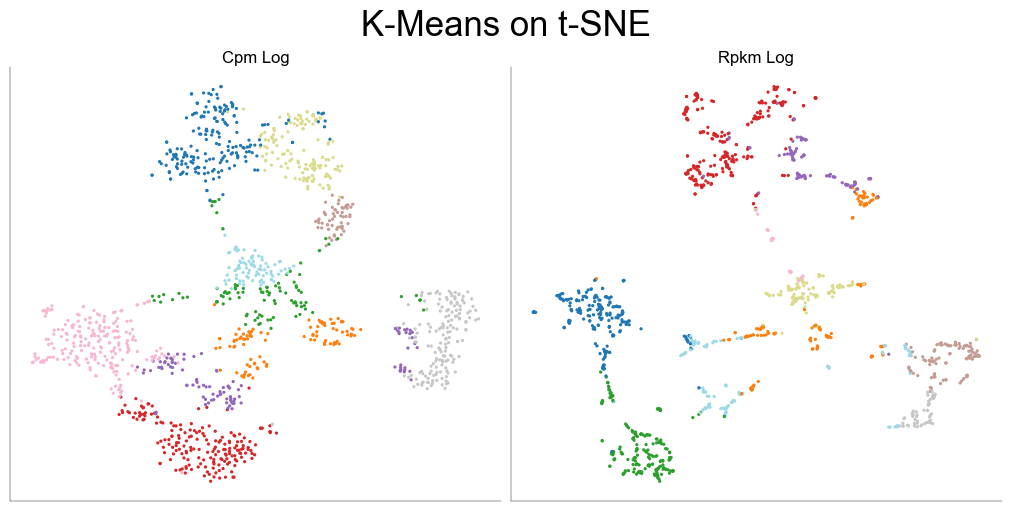

In [38]:
plot_2d_vis(
    tsne_results, "K-Means on t-SNE", k_means_labels, transpose=True
)  # Gridsearch has to run before this works

## 4.2. Leiden Clustering

We have already discussed Leiden Clustering on an exercise sheet. 

In [39]:
leiden_partition = dict()
leiden_labels = dict()
for norm_key, sub_dict in pca_results.items():
    leiden_partition[norm_key] = dict()
    leiden_labels[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        A = kneighbors_graph(pca_result, 15)
        sources, targets = A.nonzero()
        g = ig.Graph(directed=False)
        g.add_vertices(A.shape[0])
        g.add_edges(list(zip(sources, targets)))
        leiden_partition[norm_key][trans_key] = la.find_partition(
            g, la.RBConfigurationVertexPartition
        )
        leiden_labels[norm_key][trans_key] = leiden_partition[norm_key][
            trans_key
        ].membership

## 4.3. Gaussian Mixture Models
 
Gaussian Mixture Models (GMMs) assume that the data is generated from a mixture of multiple Gaussian distributions. Note that this is in particular **not** the case for our data. GMMs aim to identify the underlying components and their associated probabilities to model the data accurately. Each Gaussian component represents a cluster, and the model helps in assigning data points to their respective clusters based on the probability distribution.

In [40]:
_, counts = np.unique(cluster_colors, return_counts=True)

max_n_clusters = np.sum(counts > 0)
print(f"Maximum number of clusters: {max_n_clusters}")
gmm_labels = dict()
for norm_key, sub_dict in pca_results.items():
    gmm_labels[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        _, gmm_labels[norm_key][trans_key] = choose_n_clusters(
            pca_result, GaussianMixture, max_n_clusters
        )

Maximum number of clusters: 77
Best result: 63 clusters, BIC = 389168.40955932933
Best result: 45 clusters, BIC = 353865.4621259145


## 4.4. Negative Binomial Mixture Model

Unlike Gaussian Mixture Models (GMMs), Negative Binomial Mixture Models (NBMMs) are designed for count data instead of assuming Gaussian distributions. This characteristic makes NBMMs particularly appealing for our specific case.

While Harris et al. (2018) calculated the number of clusters inherently in their algorithm, we opted for a different approach. Similar to our GMMs approach, we conducted a grid search to determine the optimal number of clusters.

Apart from this difference, we follow the approach of Harris et al. (2018), where we fix the dispersion parameter $r=2$ and utilize hard Expectation-Maximization to optimize the model parameters. Since we already reduced ourselves to 500 genes in feature selection, we refrain from specifying a subgroup of interesting genes like the paper.

In [41]:
_, counts = np.unique(cluster_colors, return_counts=True)


max_n_clusters = 110
print(f"Maximum number of clusters: {max_n_clusters}")
nbmm_labels = dict()
for norm_key, sub_dict in count_dict.items():
    nbmm_labels[norm_key] = dict()
    for trans_key, result in sub_dict.items():
        _, nbmm_labels[norm_key][trans_key] = choose_n_clusters(
            result, NBMM, max_n_clusters
        )

Maximum number of clusters: 110
Best result: 108 clusters, BIC = 2534897.423153957
Best result: 103 clusters, BIC = 1952839.3625075861


# 5. Correlation in between Electrophysiological Features and Genes/PCs

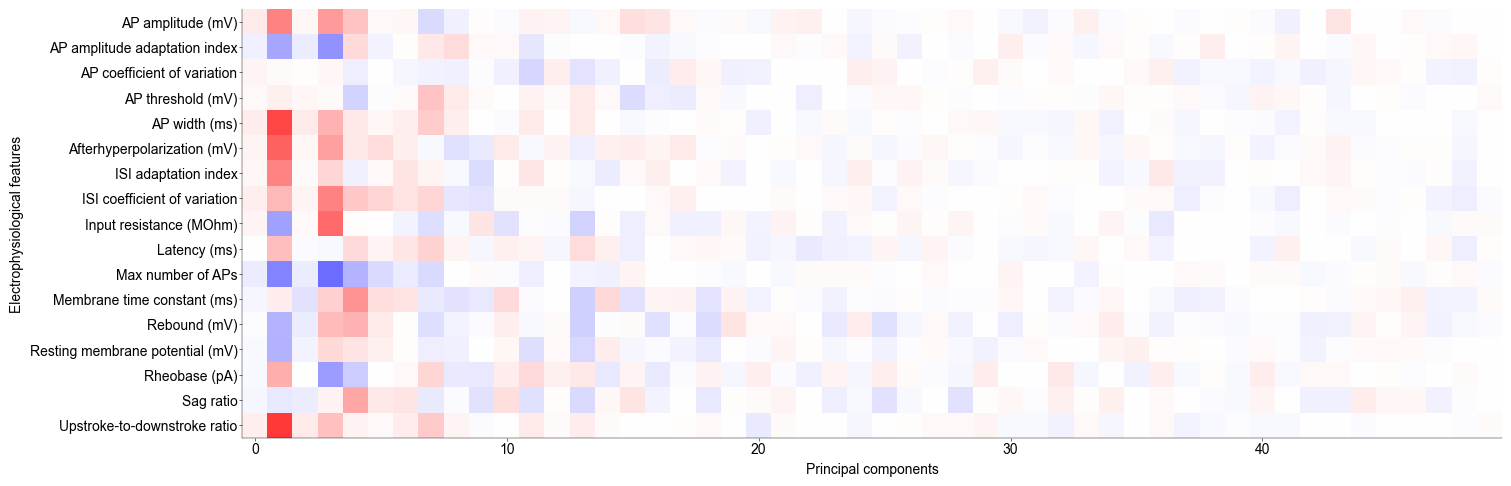

In [42]:
# calculate correlation matrix between PCs and electrophysiological features
data = np.concatenate((ephysData_filtered, pca_results["cpm"]["log"]), axis=1)
corr = np.corrcoef(data, rowvar=False)
corr = corr[ephysData_filtered.shape[1] :, : ephysData_filtered.shape[1]]


# Plot correlation matrix
fig, ax = plt.subplots(figsize=(15, 10))
im = ax.imshow(corr.T, cmap="bwr", vmin=-1, vmax=1)
ax.set_xlabel("Principal components")
ax.set_ylabel("Electrophysiological features")
ax.set_yticks(range(len(ephysNames_filtered)))
ax.set_yticklabels(ephysNames_filtered)

plt.show()

**Analysis:** The data clearly reveals strong correlations between all electrophysiological features and the second and fourth principal components, especially with respect to the second component. On the other hand, the first and third principal components demonstrate minimal correlation with the electrophysiological features. As we move beyond the first four components, there are no significant or remarkable correlations. Notably, a discernible trend emerges: correlations tend to decrease with higher principal components.

In [43]:
# TODO: TSNE plots for top correlated electrophysiological feature as colormap

# 6. References

- Renesh Bedre. (2020, March 5). reneshbedre/bioinfokit: Bioinformatics data analysis and visualization toolkit. Zenodo. http://doi.org/10.5281/zenodo.3698145.
- Kobak, D., Berens, P. The art of using t-SNE for single-cell transcriptomics. Nat Commun 10, 5416 (2019). https://doi.org/10.1038/s41467-019-13056-x
- Tallulah S Andrews , Martin Hemberg, M3Drop: dropout-based feature selection for scRNASeq, Bioinformatics, Volume 35, Issue 16, August 2019, Pages 2865–2867, https://doi.org/10.1093/bioinformatics/bty1044
- Harris KD, Hochgerner H, Skene NG, Magno L, Katona L, Bengtsson Gonzales C, et al. (2018) Classes and continua of hippocampal CA1 inhibitory neurons revealed by single-cell transcriptomics. PLoS Biol 16(6): e2006387. https://doi.org/10.1371/journal.pbio.2006387